# **Book Price Analysis**

**The flow of the project** 
1. Data Extraction: Perform webscrapping from scrach.
2. Data Cleaning & Regular Expression
3. Data Analysis : Descriptive Analysis on extracted data after cleaning.
4. Visualization the findings.
5. Build Database: To save results. 

**The project is two parts. In this part we applyed Extraction for all books are avialable for us for Analysis.**

**The second part is a Book comparison tool. We will extract the data based on specific query.**

**In** this project we extracted the bookdata from many websites like :
- **[Books To Scrape](https://books.toscrape.com)**
- **[Google books API](https://www.googleapis.com)** 
- **[Open Library](https://openlibrary.org)**

  
The structure of the extracted data will be as the following:
    **Booktitle,Price,Rating,Avialability,Category,Source**


## Import Requierd Libraries

In [38]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

## **1. Data Extraction.**

###  **Books To Scrape** 

In [39]:
# Scrape Books to Scrape 
def scrape_books_to_scrape(max_books=800):
    books = []
    url = 'https://books.toscrape.com/catalogue/page-1.html'
    base_url = 'https://books.toscrape.com/catalogue/'
    while url and len(books) < max_books:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all('article', class_='product_pod')
        for article in articles:
            if len(books) >= max_books:
                break
            title = article.h3.a['title']
            price = article.find('p', class_='price_color').text.strip()
            rating_class = article.find('p', class_='star-rating')['class'][1]
            availability = article.find('p', class_='instock availability').text.strip()
            # Extracting the category from the detail page
            detail_url = base_url + article.h3.a['href'].replace('../../../', '')
            detail_response = requests.get(detail_url)
            detail_soup = BeautifulSoup(detail_response.content, 'html.parser')
            category = detail_soup.find('ul', class_='breadcrumb').find_all('li')[2].text.strip()
            books.append({
                'title': title,
                'price': price,
                'rating': rating_class,
                'availability': availability,
                'category': category,
                'source': 'Books to Scrape'
            })
        next_button = soup.find('li', class_='next')
        if next_button:
            url = 'https://books.toscrape.com/catalogue/' + next_button.a['href']
        else:
            url = None
    return books

### **Open Library Scraping**

In [40]:
# Scrape OpenLibrary (Second source)
def scrape_openlibrary(max_books=150):
    books = []
    base_url = "https://openlibrary.org/search.json?q=python"
    response = requests.get(base_url)
    if response.status_code == 200:
        data = response.json()
        docs = data.get('docs', [])
        for doc in docs[:max_books]:
            title = doc.get('title', 'Unknown')
            price = f"£{random.randint(10, 100)}.00" 
            rating = random.choice(['One', 'Two', 'Three', 'Four', 'Five'])
            availability = 'In stock'
            subjects = doc.get('subject')
            if subjects:
                category = subjects[0]
            else:
                category = 'Programming'
            books.append({
                'title': title,
                'price': price,
                'rating': rating,
                'availability': availability,
                'category': category,
                'source': 'OpenLibrary'
            })
    return books

### **Google  Books API**

In [41]:
# Scrape Google Books API 
def scrape_google_books_api(max_books=150):
    books = []
    base_url = "https://www.googleapis.com/books/v1/volumes?q=python&maxResults=40"  # Search query and max results
    response = requests.get(base_url)
    
    if response.status_code == 200:
        data = response.json()
        items = data.get('items', [])
        for item in items[:max_books]:
            title = item['volumeInfo'].get('title', 'Unknown')
            price = 'N/A'  # Google Books API does not provide price
            rating = item['volumeInfo'].get('averageRating', 'N/A')
            availability = 'In stock'  # Not available in Google Books API, so we assume it's in stock
            categories = item['volumeInfo'].get('categories', ['N/A'])
            category = ', '.join(categories)
            books.append({
                'title': title,
                'price': price,
                'rating': rating,
                'availability': availability,
                'category': category,
                'source': 'Google Books API'
            })
    return books

### **Get Books From All Sources**

In [42]:
books1 = scrape_books_to_scrape()

KeyboardInterrupt: 

In [ ]:
books2 = scrape_openlibrary()

In [ ]:
books3 = scrape_google_books_api()

### Store Results in CSV File

In [ ]:
# Combine all books
all_books = books1 + books2 + books3

# Clean price function
def clean_price(price):
    return price.replace('Â', '').replace('Ã‚', '').replace('Â£', '£').strip()

# Clean prices
for book in all_books:
    book['price'] = clean_price(book['price'])

# Save to CSV
# df = pd.DataFrame(all_books)
# df.to_csv("books.csv", index=False, encoding='utf-8-sig')

### **Let's start Exploring**

In [ ]:
# Read the saved file
df = pd.read_csv("books.csv")
df.head(10)

,title,price,rating,availability,category,source
0,A Light in the Attic,£51.77,Three,In stock,Poetry,Books to Scrape
1,Tipping the Velvet,£53.74,One,In stock,Historical Fiction,Books to Scrape
2,Soumission,£50.10,One,In stock,Fiction,Books to Scrape
3,Sharp Objects,£47.82,Four,In stock,Mystery,Books to Scrape
4,Sapiens: A Brief History of Humankind,£54.23,Five,In stock,History,Books to Scrape
5,The Requiem Red,£22.65,One,In stock,Young Adult,Books to Scrape
6,The Dirty Little Secrets of Getting Your Dream...,£33.34,Four,In stock,Business,Books to Scrape
7,The Coming Woman: A Novel Based on the Life of...,£17.93,Three,In stock,Default,Books to Scrape
8,The Boys in the Boat: Nine Americans and Their...,£22.60,Four,In stock,Default,Books to Scrape
9,The Black Maria,£52.15,One,In stock,Poetry,Books to Scrape


**From Last Sample we got that:**
- **In cleaning we have to encode features like Rating and avialability**
- **The Price must be transferd to Float**

In [ ]:
print(df.columns)

Index(['title', 'price', 'rating', 'availability', 'category', 'source'], dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         290 non-null    object
 1   price         250 non-null    object
 2   rating        257 non-null    object
 3   availability  290 non-null    object
 4   category      289 non-null    object
 5   source        290 non-null    object
dtypes: object(6)
memory usage: 13.7+ KB


## **2. Cleaning & Regular Expressions**

### **1. Handle Missing Values**

In [43]:
# Replace missing price with 'Free Access'
df['price'] = df['price'].fillna('Free Access')

# Drop rows with missing rating or category
df = df.dropna()

In [44]:
# Check for missing values
print(df.isna().sum())

title               0
price               0
rating              0
availability        0
category            0
source              0
rating_num          0
availability_num    0
dtype: int64


### **2. Clean Price**

In [45]:
# If price is not "Free Access", remove the £ sign and convert to float
def clean_price(value):
    if value == 'Free Access':
        return 0.0
    else:
        # Convert value to string before using regex
        value_str = str(value)
        price_num = re.sub(r'[^\d\.]', '', value_str)
        return float(price_num)
df['price'] = df['price'].apply(clean_price)

C:\Users\yasse\AppData\Local\Temp\ipykernel_10968\1820785357.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].apply(clean_price)


In [46]:
df['title'] = df['title'].replace('????', 'unknown')
df['rating_num'].dropna()


C:\Users\yasse\AppData\Local\Temp\ipykernel_10968\1584531310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].replace('????', 'unknown')


0      3
1      1
2      1
3      4
4      5
      ..
245    4
246    5
247    5
248    1
249    4
Name: rating_num, Length: 250, dtype: Int64

### **3. Preprocessing**

In [47]:
rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
df['rating_num'] = df['rating'].map(rating_map)
df['rating_num'] = df['rating_num'].astype(float).astype('Int64')

df['availability_num'] = df['availability'].apply(lambda x: 1 if 'In stock' in x else 0)

df.head()

C:\Users\yasse\AppData\Local\Temp\ipykernel_10968\698928768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_num'] = df['rating'].map(rating_map)
C:\Users\yasse\AppData\Local\Temp\ipykernel_10968\698928768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_num'] = df['rating_num'].astype(float).astype('Int64')
C:\Users\yasse\AppData\Local\Temp\ipykernel_10968\698928768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,title,price,rating,availability,category,source,rating_num,availability_num
0,A Light in the Attic,51.77,Three,In stock,Poetry,Books to Scrape,3,1
1,Tipping the Velvet,53.74,One,In stock,Historical Fiction,Books to Scrape,1,1
2,Soumission,50.10,One,In stock,Fiction,Books to Scrape,1,1
3,Sharp Objects,47.82,Four,In stock,Mystery,Books to Scrape,4,1
4,Sapiens: A Brief History of Humankind,54.23,Five,In stock,History,Books to Scrape,5,1


## **Books Data Analysis**

In [48]:
print("BASIC DESCRIPTIVE STATISTICS\n")
print("Dataset shape:", df.shape)
print("Data types:", df.dtypes)
df[['price', 'rating_num']].describe()

BASIC DESCRIPTIVE STATISTICS

Dataset shape: (250, 8)
Data types: title                object
price               float64
rating               object
availability         object
category             object
source               object
rating_num            Int64
availability_num      int64
dtype: object


,price,rating_num
count,250.000000,250.0
mean,42.766440,2.896
std,21.958568,1.413214
min,10.000000,1.0
25%,24.030000,2.0
50%,39.125000,3.0
75%,55.882500,4.0
max,99.000000,5.0


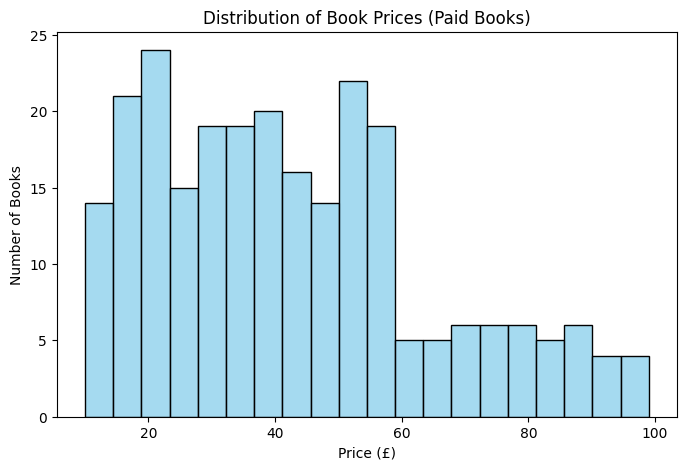

In [49]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], color='skyblue', bins=20)
plt.title('Distribution of Book Prices (Paid Books)')
plt.xlabel('Price (£)')
plt.ylabel('Number of Books')
plt.show()

In [50]:
print("PRICE ANALYSIS")
print(f"Mean price: £{df['price'].mean():.2f}")
print(f"Median price: £{df['price'].median():.2f}")
print(f"Minimum price: £{df['price'].min():.2f}")
print(f"Maximum price: £{df['price'].max():.2f}")
print(f"Standard deviation: £{df['price'].std():.2f}")

PRICE ANALYSIS
Mean price: £42.77
Median price: £39.12
Minimum price: £10.00
Maximum price: £99.00
Standard deviation: £21.96


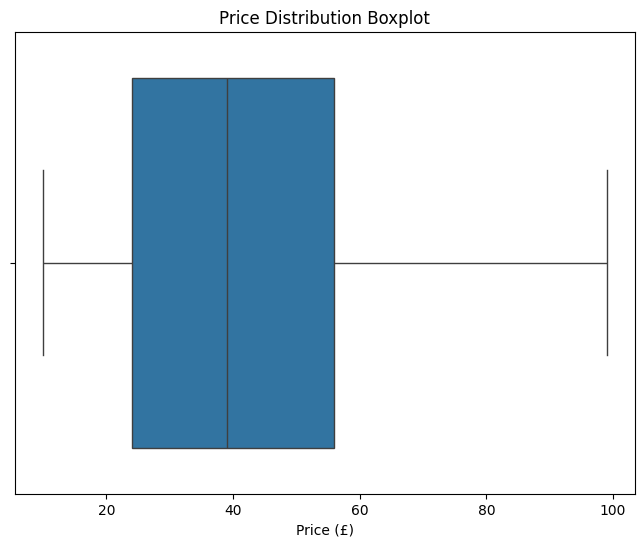

In [51]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['price'])
plt.title('Price Distribution Boxplot')
plt.xlabel('Price (£)')
plt.show()

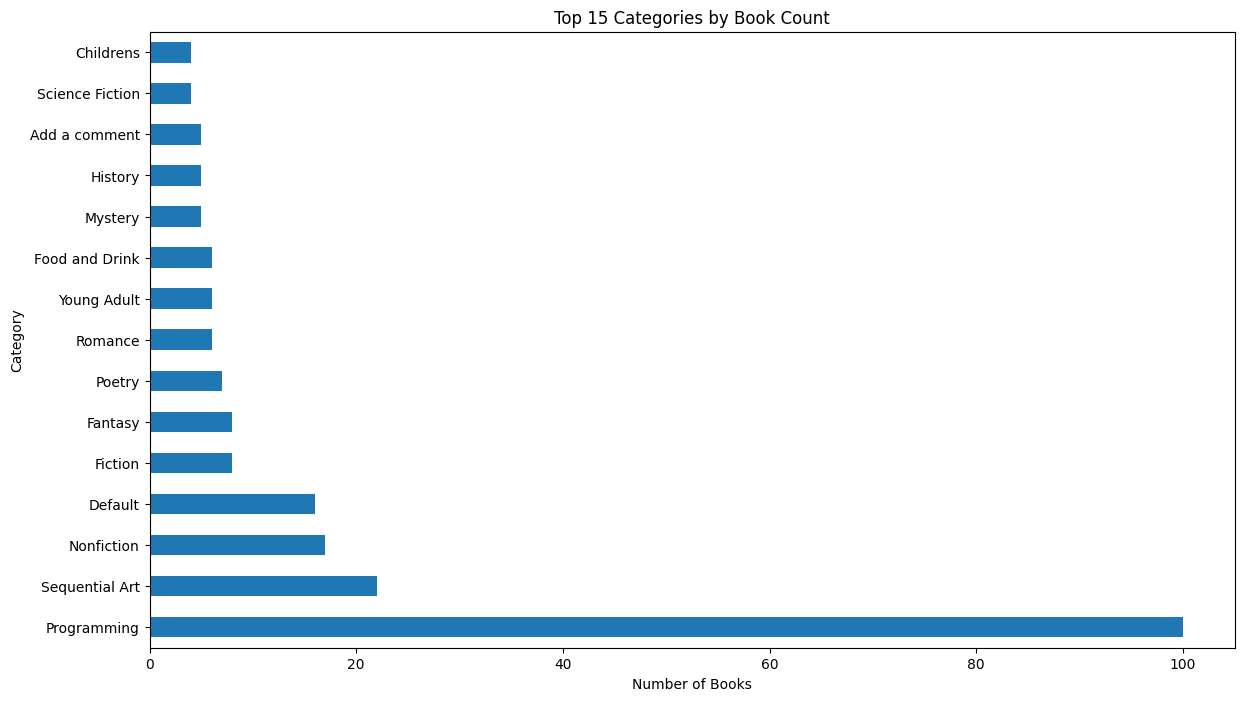

In [52]:
plt.figure(figsize=(14, 8))
df['category'].value_counts().head(15).plot(kind='barh')
plt.title('Top 15 Categories by Book Count')
plt.xlabel('Number of Books')
plt.ylabel('Category')
plt.show()

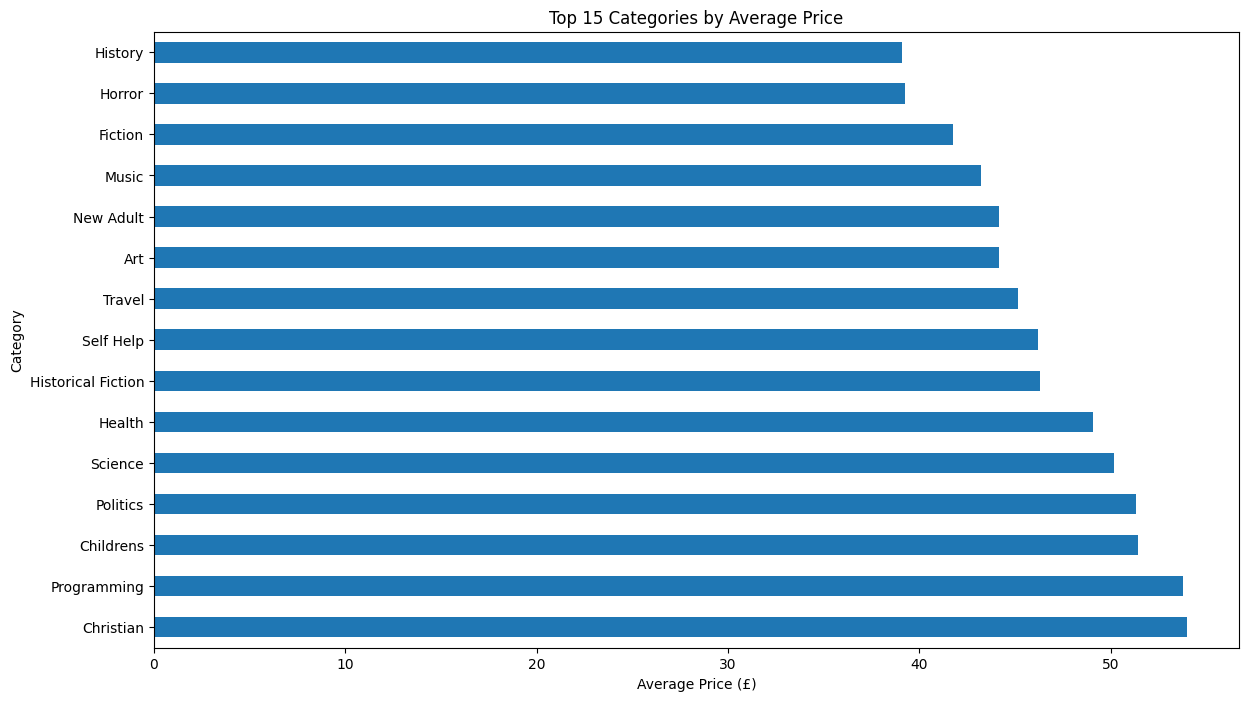

In [53]:
plt.figure(figsize=(14, 8))
df.groupby('category')['price'].mean().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 Categories by Average Price')
plt.xlabel('Average Price (£)')
plt.ylabel('Category')
plt.show()

SOURCE ANALYSIS
Books by source:
 source
Books to Scrape    150
OpenLibrary        100
Name: count, dtype: int64


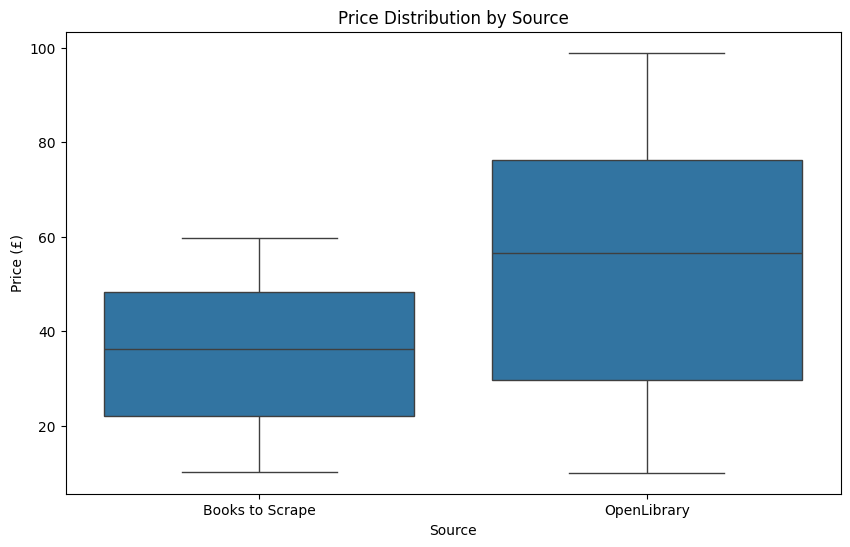

In [54]:
print("SOURCE ANALYSIS")
print("Books by source:\n", df['source'].value_counts())

# Price distribution by source
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y=df['price'], data=df)
plt.title('Price Distribution by Source')
plt.xlabel('Source')
plt.ylabel('Price (£)')
plt.show()

In [55]:
print(df.columns)
print(df.dtypes)

Index(['title', 'price', 'rating', 'availability', 'category', 'source',
       'rating_num', 'availability_num'],
      dtype='object')
title                object
price               float64
rating               object
availability         object
category             object
source               object
rating_num            Int64
availability_num      int64
dtype: object


## 5. Database Connection

In [56]:
from sqlalchemy import create_engine
import urllib

# إعداد الاتصال
params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=ALNAFRAWI;"
    "DATABASE=BooksDB;"
    "Trusted_Connection=yes;"
)

# إنشاء محرك SQLAlchemy
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# حفظ البيانات في جدول اسمه books
df.to_sql('books', con=engine, if_exists='append', index=False)


250